# 9章 CIFAR10を使った画像認識

In [3]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [4]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [5]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

/home/miyawaki/anaconda3/envs/irvs_get_started/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

### GPUチェック

In [7]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 9.3 CNNの処理概要

In [8]:
data_root = './data'

# サンプルの手書き数字データを取得
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

In [9]:
# 対角線上にのみ重みを持つ特殊な畳み込み関数を作る
conv1 = nn.Conv2d(1, 1, 3)

# biasを0に
nn.init.constant_(conv1.bias, 0.0)

# weightを特殊な値に
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [10]:
# 手書き数字に3回畳み込み処理を行う
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

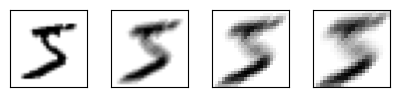

In [11]:
# 結果の画面表示

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 PyTorchでのCNN実装

### nn.Conv2d とnn.MaxPool2d

In [12]:
# CNN前半部分 レイヤー関数の定義

conv1 = nn.Conv2d(3, 32, 3) #3つのチャンネルを32個に変換
relu = nn.ReLU(inplace=True)
# q: 32個のチャンネルを32個に変換するのは何のため？
# a: 32個のチャンネルを32個に変換するのは、32個のフィルターを使って畳み込みを行うため
conv2 = nn.Conv2d(32, 32, 3) #32個のチャンネルを32個に変換,これは
maxpool = nn.MaxPool2d((2,2))

In [13]:
# conv1の確認
print(conv1)

# conv1の内部変数のshape確認
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2の内部変数のshape確認
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [14]:
# conv1のweight[0]とは、出力チャネル0用の重み
w = conv1.weight[0]

# waeight[0]のshapeと値の確認
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[-0.0959  -0.03798 -0.11796]
  [-0.0926   0.06591  0.01862]
  [ 0.00875  0.16556  0.1006 ]]

 [[ 0.10478 -0.1857  -0.06779]
  [ 0.01917  0.09869  0.10707]
  [ 0.14213 -0.11185 -0.0298 ]]

 [[ 0.15777  0.00704 -0.10597]
  [-0.05974 -0.05597  0.11592]
  [-0.01508  0.10953  0.19092]]]


In [15]:
# ダミーで入力と同じサイズのTensorを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [16]:
# CNNの前半部分をシミュレーションする

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [17]:
# それぞれのshapeの確認

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [18]:
# 関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [19]:
# 動作テスト
outputs = features(inputs)

# 結果確認
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [20]:
# 関数定義
flatten = nn.Flatten()

# 動作テスト
outputs2 = flatten(outputs)

# 結果確認
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.4 共通関数の定義

### eval_loss 損失計算用

In [21]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

### fit 学習用

In [22]:
# 学習用関数
# 内容理解
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            # torch.maxは最大値と最大値のインデックスの両方を返す, 第２引数は次元指定、0は列方向、1は行方向
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)

            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

### eval_history 学習ログ解析用

In [23]:
# 学習ログ解析
# 内容理解
def evaluate_history(history):
    #損失と精度の確認
    # -1を指定することで、最後の行を取得
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

### show_images_labels イメージとラベルの表示

In [24]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


### torch_seed 乱数固定用

In [25]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


## 9.6 データ準備

In [26]:
# Transformsの定義

# transformer1 1階テンソル化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [27]:
# データ取得用関数 Datasets

data_root = './data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### データセットの確認

In [28]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [29]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [30]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


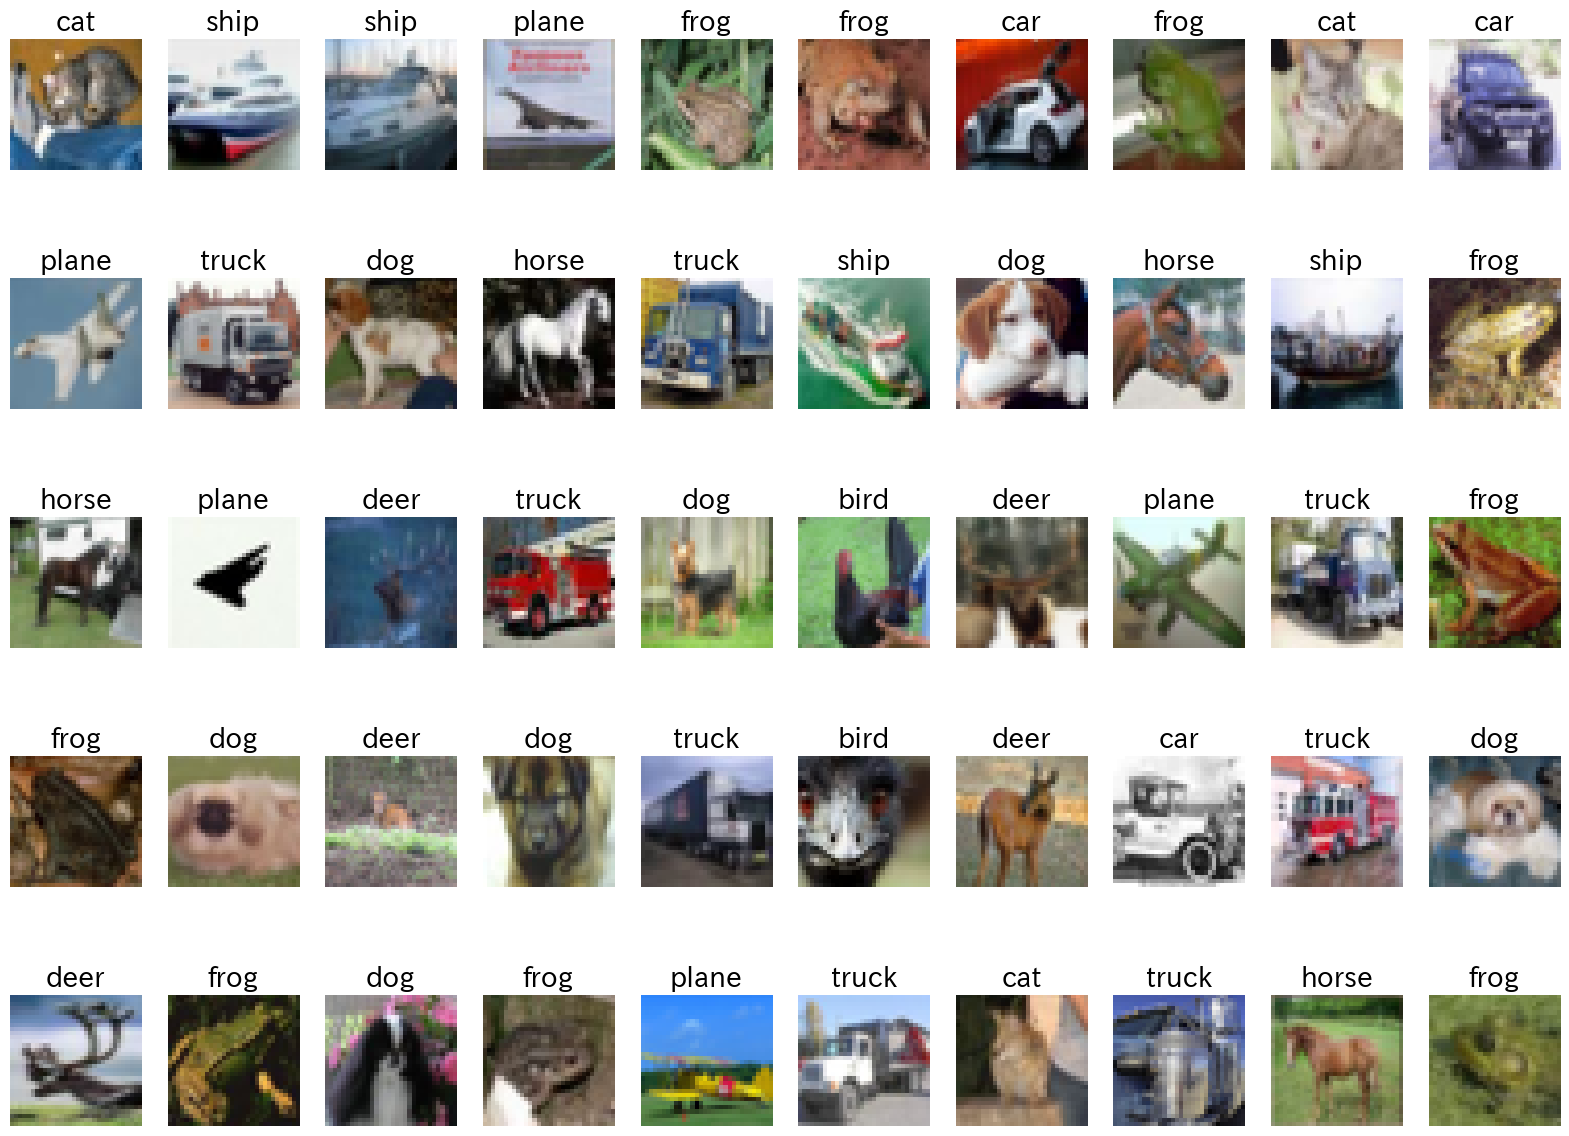

In [31]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

## 9.7 モデル定義(全結合版)

### 学習用パラメータ設定

In [32]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [33]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### モデルインスタンス生成とGPUの割り当て

In [34]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [35]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [36]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

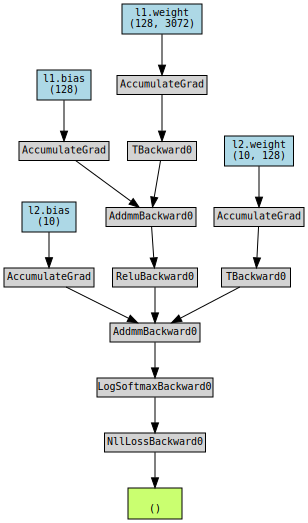

In [37]:
# 損失計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.8 結果(全結合版)

### 学習

In [38]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### 評価

In [ ]:
# 評価

evaluate_history(history)

## 9.9 モデル定義(CNN版)

In [39]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### モデルインスタンスの生成

In [40]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [41]:
# モデルの概要表示

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [42]:
# モデルのサマリー表示

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

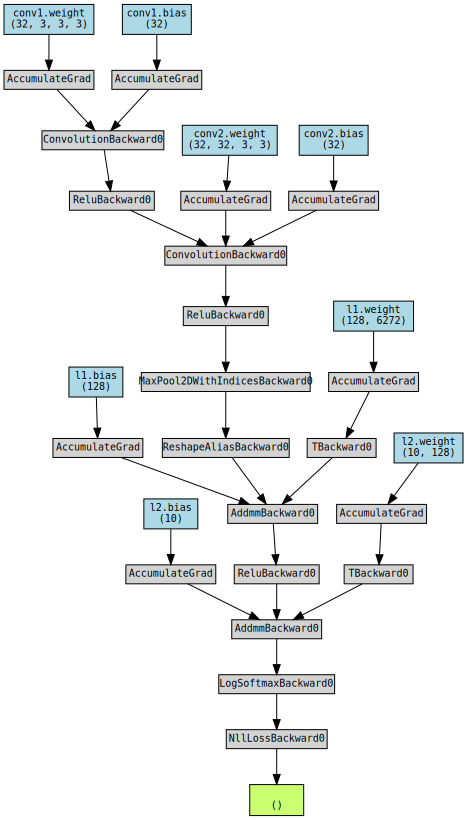

In [43]:
# 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.10 結果(CNN版)

### 学習

In [44]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### 評価

In [45]:
# 評価

evaluate_history(history2)

IndexError: index 0 is out of bounds for axis 0 with size 0

Exception ignored in: <function tqdm.__del__ at 0x1553c0072d40>
Traceback (most recent call last):
  File "/home/miyawaki/anaconda3/envs/irvs_get_started/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/miyawaki/anaconda3/envs/irvs_get_started/lib/python3.10/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x1553c0072d40>
Traceback (most recent call last):
  File "/home/miyawaki/anaconda3/envs/irvs_get_started/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/miyawaki/anaconda3/envs/irvs_get_started/lib/python3.10/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


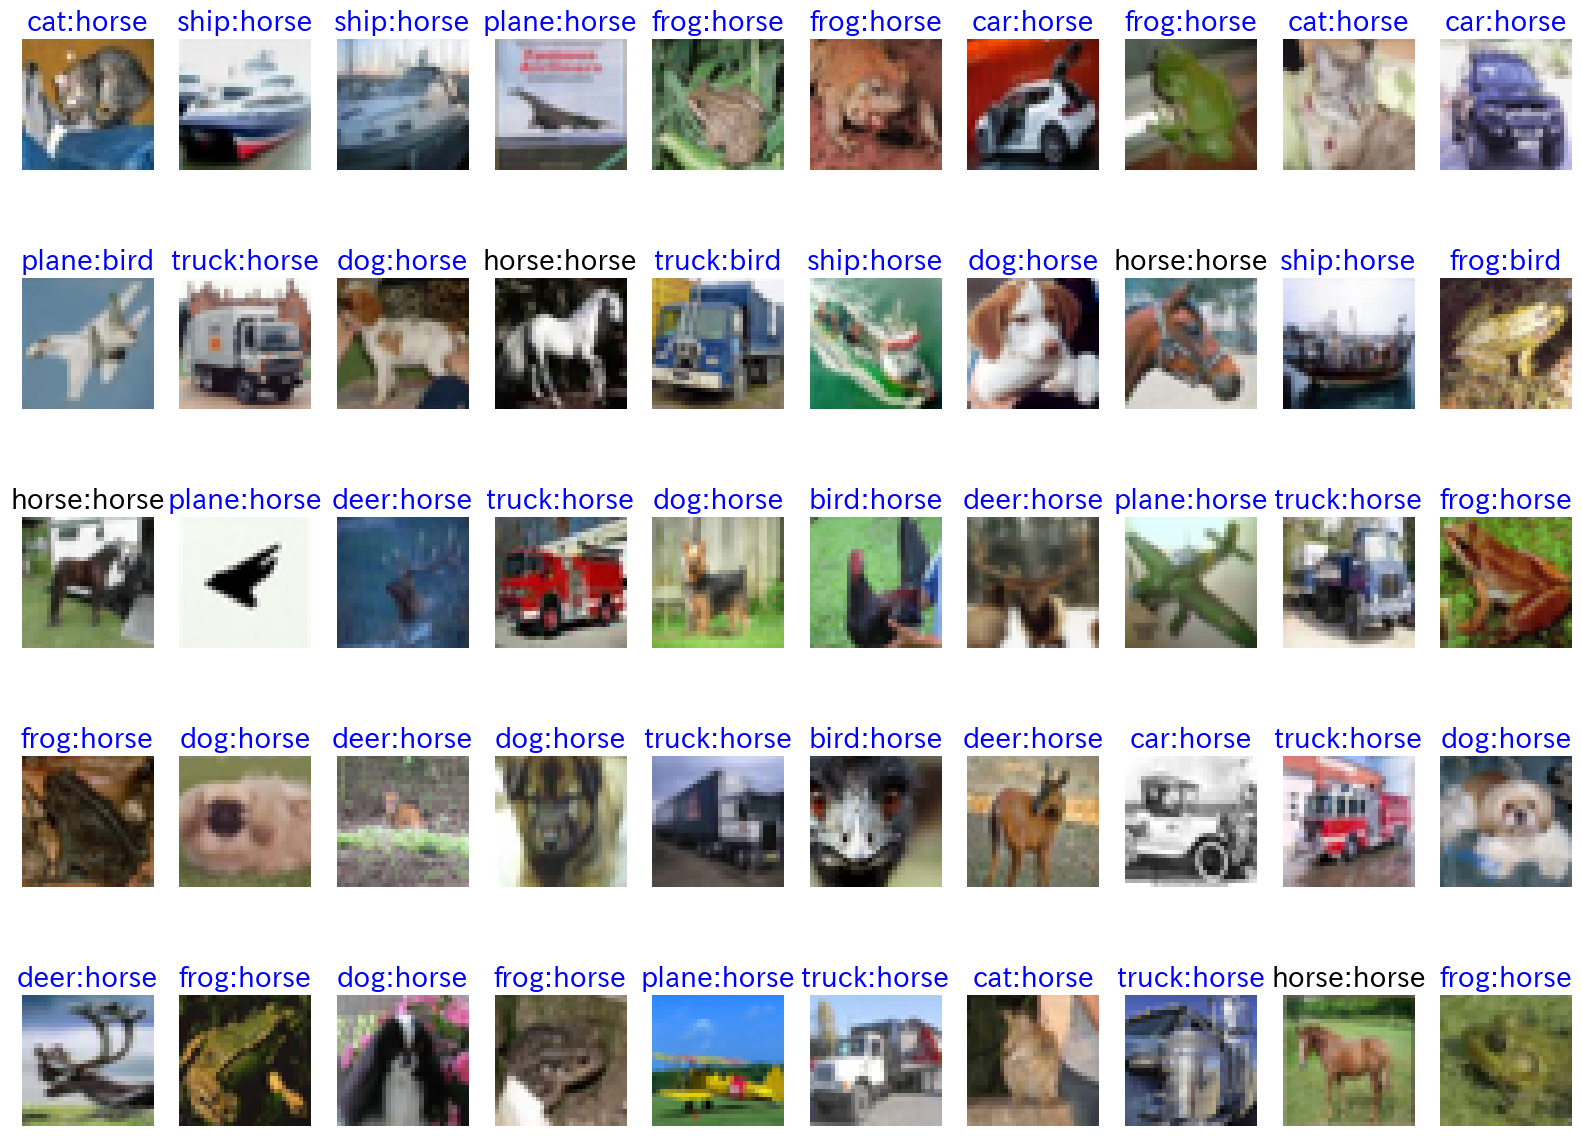

In [46]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)